In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/sample_data/PCOS Preprocessed.csv')
display(df.head(2))
print(df.shape)

,Age (yrs),BMI,Cycle(R/I),LH(mIU/mL),FSH/LH,TSH (mIU/L),AMH(ng/mL),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),avg_num_folicol,PCOS (Y/N)
0,-0.634606,-1.236018,-0.621534,-0.032219,-0.078253,-0.613338,-0.604743,-0.778037,-0.61367,-0.665332,-0.824385,0
1,0.845230,0.146227,-0.621534,-0.062129,-0.012120,0.047632,-0.696716,-0.778037,-0.61367,-0.665332,-0.580873,0


(728, 12)


In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop('PCOS (Y/N)',axis=1)
y = df['PCOS (Y/N)']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

In [ ]:
# Define numeric feature columns (excluding the target)
numeric_cols = df.drop(columns='PCOS (Y/N)').columns.to_list()

# Sample original data with replacement
synthetic_df = df.sample(n=250, replace=True, random_state=42).copy()

# Add Gaussian noise only to feature columns
synthetic_df[numeric_cols] += np.random.normal(
    loc=0,
    scale=0.2,  # Adjust as needed
    size=synthetic_df[numeric_cols].shape
)

In [ ]:
synthetic_df

In [ ]:
synthetic_df.to_csv('PCOS_synthetic_external.csv',index=False)

In [ ]:
X_test_syn = synthetic_df.drop('PCOS (Y/N)',axis=1)
y_test_syn = synthetic_df['PCOS (Y/N)']

# Traditional and Advanced ML Models

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


In [ ]:
# Define a more extensive hyperparameter search space
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Covers a wider range of regularization strengths
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],  # Includes more solvers
    'penalty': ['l1', 'l2', 'elasticnet', None],  # ElasticNet added
    'l1_ratio': np.linspace(0, 1, 10)  # Used only when penalty='elasticnet'
}

# Initialize Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(logreg, param_grid, n_iter=100, cv=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get best model
best_logreg = random_search.best_estimator_

# Make predictions
y_pred = best_logreg.predict(X_test)

# Evaluate the model
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': np.float64(0.8888888888888888), 'C': np.float64(206.913808111479)}
Accuracy: 0.8901
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        91
           1       0.86      0.93      0.89        91

    accuracy                           0.89       182
   macro avg       0.89      0.89      0.89       182
weighted avg       0.89      0.89      0.89       182



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
410 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_sol

In [ ]:
# ROC-AUC
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for the positive class (class 1)
y_proba = best_logreg.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)

print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.9521796884434248


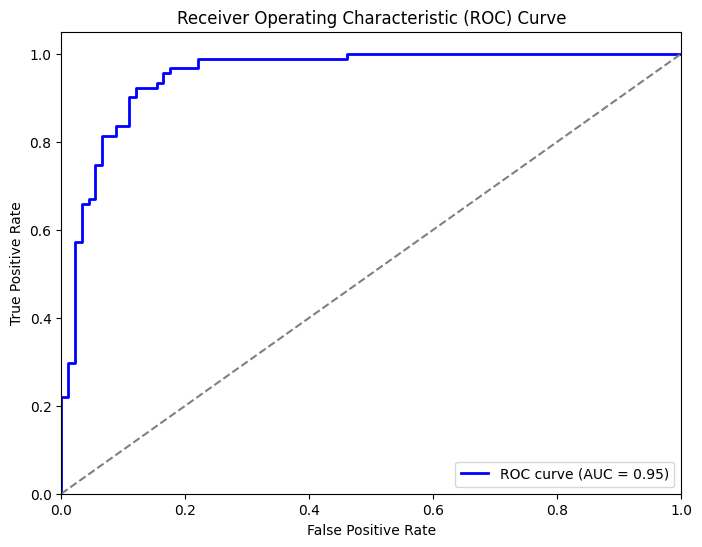

In [ ]:
# ROC-AUC Plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_proba = best_logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define hyperparameter search space
param_grid = {
    'n_estimators': np.arange(50, 200, 50),  # Reduced tree range
    'max_depth': np.arange(5, 30, 5),  # Shallower trees
    'min_samples_split': np.arange(2, 10, 2),  # Lower range for split
    'min_samples_leaf': np.arange(1, 10, 2),  # Lower range for leaf nodes
    'max_features': ['sqrt', 'log2'],  # Remove 'None' to speed up
    'bootstrap': [True]  # Fix to True (reduces search space)
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(rf, param_grid, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get best model
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test)

# Evaluate the model
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'n_estimators': np.int64(100), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(5), 'max_features': 'log2', 'max_depth': np.int64(25), 'bootstrap': True}
Accuracy: 0.8846
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88        91
           1       0.86      0.91      0.89        91

    accuracy                           0.88       182
   macro avg       0.89      0.88      0.88       182
weighted avg       0.89      0.88      0.88       182



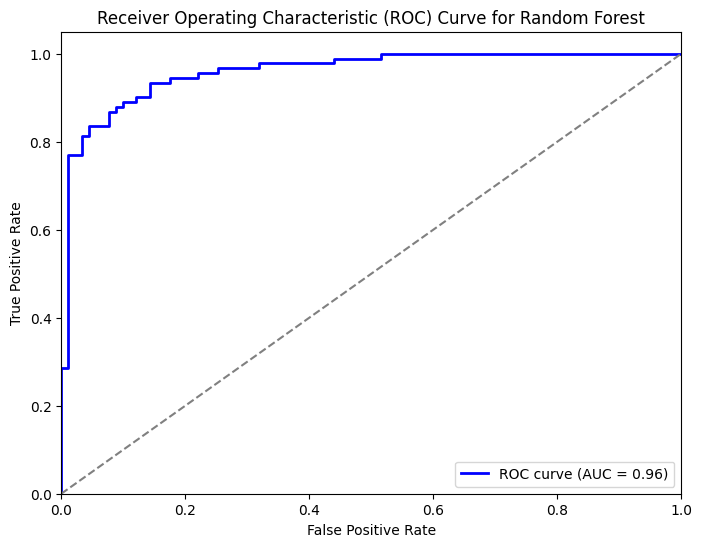

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()


In [ ]:

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions (needed for SHAP to compare actual outputs with SHAP explanations)
y_pred = rf_model.predict(X_test)

# Create SHAP explainer object for Random Forest model (TreeExplainer is efficient for tree-based models)
explainer = shap.TreeExplainer(rf_model)

# Get SHAP values for all test samples (you can adjust the number of test samples if needed)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values using a summary plot for feature importance (for PCOS class)
shap.summary_plot(shap_values[1], X_test)  # Index 1 for the PCOS (1) class

# Alternatively, visualize SHAP values for an individual prediction (first test sample for PCOS)
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])  # First test sample


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

## XGBoost

In [ ]:
from xgboost import XGBClassifier
import numpy as np

In [ ]:
# Optimized hyperparameter search space
param_grid = {
    'n_estimators': np.arange(50, 300, 50),  # Trees (50-300)
    'max_depth': np.arange(3, 10, 2),  # Tree depth (3-10)
    'learning_rate': np.linspace(0.01, 0.3, 5),  # Learning rate (0.01-0.3)
    'subsample': np.linspace(0.6, 1.0, 3),  # Subsampling ratio
    'colsample_bytree': np.linspace(0.6, 1.0, 3),  # Feature selection per tree
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Regularization
}

# Initialize XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform Randomized Search with reduced complexity
random_search = RandomizedSearchCV(
    xgb, param_grid, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

# Get best model
best_xgb = random_search.best_estimator_

# Make predictions
y_pred = best_xgb.predict(X_test)

# Evaluate the model
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'subsample': np.float64(0.6), 'n_estimators': np.int64(200), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.22749999999999998), 'gamma': 0.4, 'colsample_bytree': np.float64(0.8)}
Accuracy: 0.9121
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91        91
           1       0.89      0.93      0.91        91

    accuracy                           0.91       182
   macro avg       0.91      0.91      0.91       182
weighted avg       0.91      0.91      0.91       182



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
y_pred_syn = best_xgb.predict(X_test_syn)
print(classification_report(y_pred_syn, y_test_syn))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       103
           1       0.95      0.80      0.87       147

    accuracy                           0.86       250
   macro avg       0.86      0.87      0.86       250
weighted avg       0.88      0.86      0.86       250



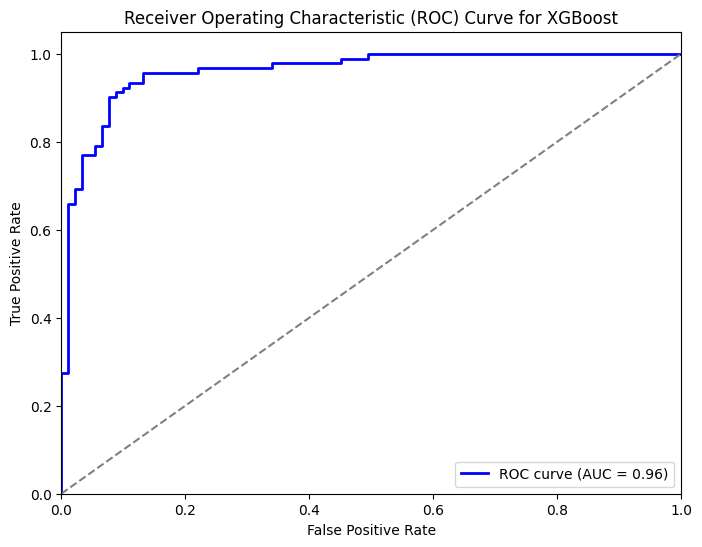

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()


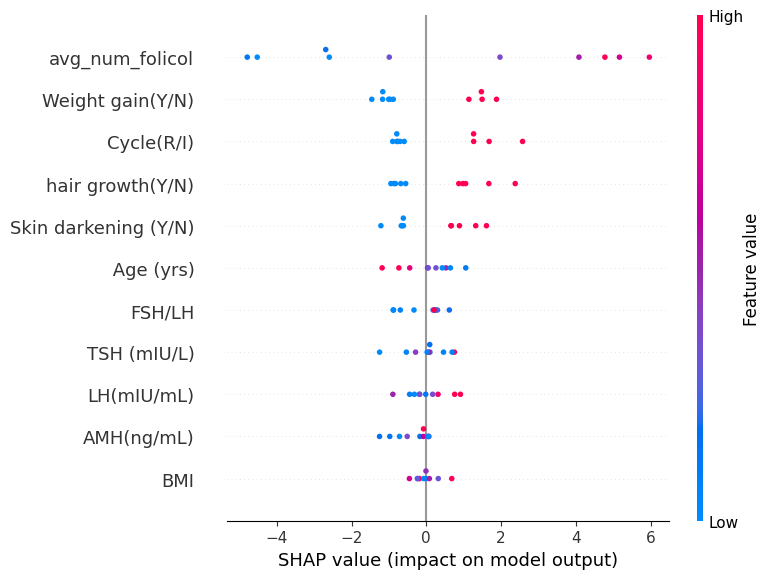

IndexError: invalid index to scalar variable.

In [ ]:

import xgboost as xgb
from xgboost import XGBClassifier

# Initialize and train the XGBoost model
xgboost_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6)
xgboost_model.fit(X_train, y_train)

# Make predictions (needed for SHAP to compare actual outputs with SHAP explanations)
y_pred = xgboost_model.predict(X_test)

# Create SHAP explainer object for XGBoost model (TreeExplainer is fast for tree-based models)
explainer = shap.TreeExplainer(xgboost_model)

# Get SHAP values for a set of predictions (e.g., 10 test samples)
shap_values = explainer.shap_values(X_test[:10])  # You can adjust the number of test samples

# Visualize SHAP values (summary plot for feature importance)
shap.summary_plot(shap_values, X_test[:10])

# Visualize SHAP values for an individual prediction (first test sample)
shap.initjs()  # Initializes JavaScript for interactive plots
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])  # Example for the first prediction



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:31:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


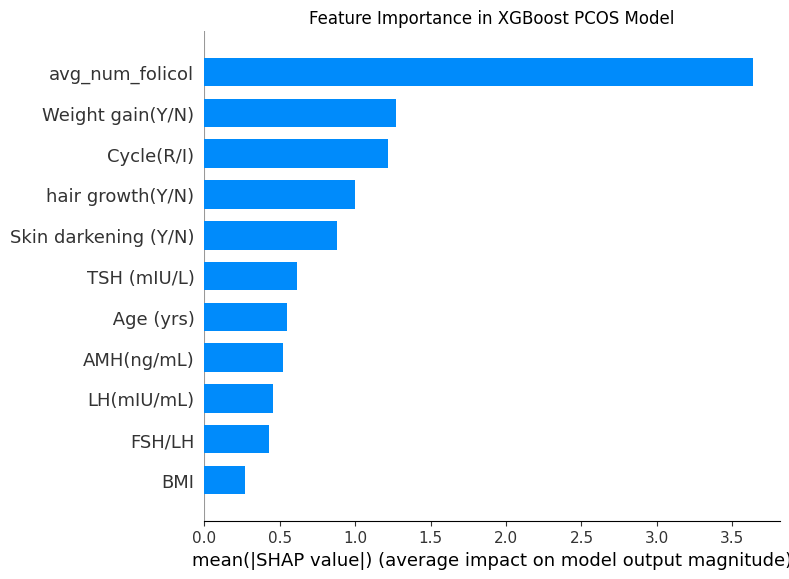

In [ ]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train, y_train, X_test are defined and prepared (e.g., as pandas DataFrame)
# Assuming feature_names is a list containing the names of the features

# Prepare DMatrix for XGBoost
dmatrix = xgb.DMatrix(X_train, label=y_train)

# Define the XGBoost parameters (adjust as needed)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 1000
}

# Train the XGBoost model
num_rounds = 1000
model = xgb.train(params, dmatrix, num_rounds)

# Generate SHAP values using the trained XGBoost model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create SHAP summary plot
plt.figure(figsize=(14,6))
shap.summary_plot(shap_values, X_test,
                 feature_names=X_test.columns,  # Ensure X_test is a DataFrame
                 plot_type="bar",  # Use bar plot for feature importance
                 show=False)

# Set plot title and layout
plt.title("Feature Importance in XGBoost PCOS Model")
plt.tight_layout()

# Save the summary plot as an image
plt.savefig('xgboost_shap_summary.png', dpi=300)

# Optionally, display the plot
plt.show()


## CatBoost

In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
import numpy as np

In [ ]:
param_grid = {
    'iterations': np.arange(100, 500, 100),  # Number of boosting iterations
    'depth': np.arange(4, 10, 2),  # Tree depth (4-10)
    'learning_rate': np.linspace(0.01, 0.3, 5),  # Learning rate (0.01-0.3)
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2 regularization
    'border_count': [32, 64, 128],  # Number of bins for feature splitting
}

# Initialize CatBoost model (silent=True avoids too many logs)
catboost = CatBoostClassifier(verbose=0, random_state=42)

# Perform Randomized Search with reduced complexity
random_search = RandomizedSearchCV(
    catboost, param_grid, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

# Get best model
best_catboost = random_search.best_estimator_

# Make predictions
y_pred = best_catboost.predict(X_test)

# Evaluate the model
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'learning_rate': 0.3, 'l2_leaf_reg': 9, 'iterations': 400, 'depth': 8, 'border_count': 32}
Accuracy: 0.9121
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        91
           1       0.89      0.95      0.91        91

    accuracy                           0.91       182
   macro avg       0.91      0.91      0.91       182
weighted avg       0.91      0.91      0.91       182



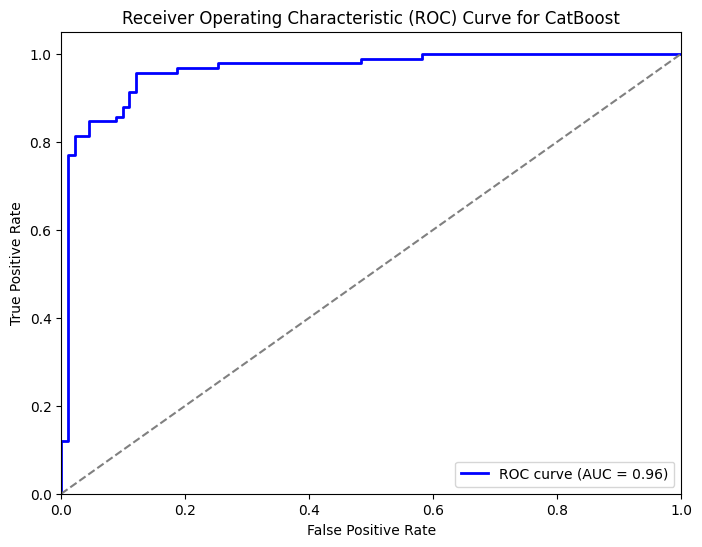

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_proba_catboost = best_catboost.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(y_test, y_proba_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_catboost:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for CatBoost')
plt.legend(loc='lower right')
plt.show()


0:	learn: 0.6404349	total: 60.7ms	remaining: 1m
100:	learn: 0.0574345	total: 1.7s	remaining: 15.1s
200:	learn: 0.0264077	total: 3.26s	remaining: 13s
300:	learn: 0.0158105	total: 4s	remaining: 9.3s
400:	learn: 0.0112958	total: 4.58s	remaining: 6.85s
500:	learn: 0.0089934	total: 5.43s	remaining: 5.41s
600:	learn: 0.0076272	total: 6.48s	remaining: 4.3s
700:	learn: 0.0067773	total: 7.13s	remaining: 3.04s
800:	learn: 0.0062383	total: 7.77s	remaining: 1.93s
900:	learn: 0.0060238	total: 8.16s	remaining: 897ms
999:	learn: 0.0059297	total: 8.59s	remaining: 0us


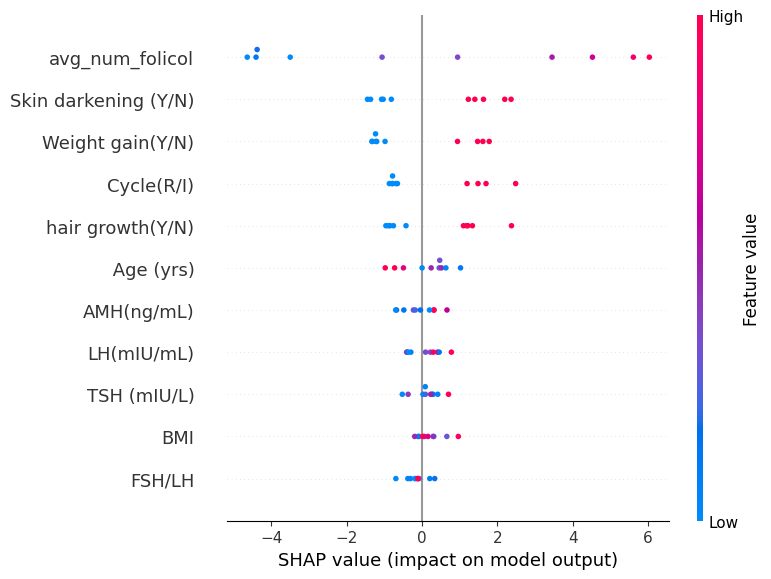

IndexError: invalid index to scalar variable.

In [ ]:
import shap
from catboost import CatBoostClassifier

# Initialize and train the CatBoost model
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6)
catboost_model.fit(X_train, y_train, verbose=100)

# Make predictions (needed for SHAP to compare actual outputs with SHAP explanations)
y_pred = catboost_model.predict(X_test)

# Create SHAP explainer object for CatBoost model (TreeExplainer is fast for tree-based models)
explainer = shap.TreeExplainer(catboost_model)

# Get SHAP values for a set of predictions (e.g., 10 test samples)
shap_values = explainer.shap_values(X_test[:10])  # You can choose the number of test samples

# Visualize SHAP values (summary plot for feature importance)
shap.summary_plot(shap_values, X_test[:10])

# Visualize SHAP values for an individual prediction (first test sample)
shap.initjs()  # Initializes JavaScript for interactive plots
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])  # Example for the first prediction

## TabNet

In [ ]:
!pip install pytorch-tabnet scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
import torch


TabNet Hyperparameter Tuning

In [ ]:


# Expanded grid for hyperparameters
param_grid = {
    'n_d': [8, 16, 32],  # More options for decision features
    'n_a': [8, 16, 32],  # More options for attention features
    'learning_rate': [1e-3, 1e-4, 1e-5],  # Expanded learning rate options
    'lambda_sparse': [1e-3, 1e-4, 1e-5],  # More options for regularization
    'n_steps': [3, 4, 5],  # Increase the decision steps
}

# Initialize variables to store the best result
best_accuracy = 0
best_params = {}

# Perform grid search over the defined parameter grid
for n_d in param_grid['n_d']:
    for n_a in param_grid['n_a']:
        for learning_rate in param_grid['learning_rate']:
            for lambda_sparse in param_grid['lambda_sparse']:
                for n_steps in param_grid['n_steps']:

                    print(f"Training with n_d={n_d}, n_a={n_a}, learning_rate={learning_rate}, "
                          f"lambda_sparse={lambda_sparse}, n_steps={n_steps}")

                    # Initialize TabNet model with the selected hyperparameters
                    model = TabNetClassifier(
                        n_d=n_d,
                        n_a=n_a,
                        n_steps=n_steps,  # Increase the number of decision steps
                        gamma=1.3,
                        lambda_sparse=lambda_sparse,
                        optimizer_fn=torch.optim.Adam,
                        optimizer_params={'lr': learning_rate},
                        mask_type='sparsemax'
                    )

                    # Train the model with early stopping and more epochs (e.g., 50)
                    model.fit(
                        X_train=X_train.values, y_train=y_train.values,
                        eval_set=[(X_test.values, y_test.values)],
                        max_epochs=50,  # Increase epochs for more thorough training
                        batch_size=1024,
                        patience=10,  # Increase early stopping patience
                        virtual_batch_size=128
                    )

                    # Predict and evaluate the model
                    y_pred = model.predict(X_test.values)
                    accuracy = accuracy_score(y_test, y_pred)

                    # Update best model if necessary
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            'n_d': n_d,
                            'n_a': n_a,
                            'learning_rate': learning_rate,
                            'lambda_sparse': lambda_sparse,
                            'n_steps': n_steps
                        }

# Print the best parameters and accuracy
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)


Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022
Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022
Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:01s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561
Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022
Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022
Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.57022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.57022
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52445 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52445
Training with n_d=8, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4561  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4561
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216
Training with n_d=8, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216
Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522
Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216
Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522
Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522
Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216
Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522
Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.6568  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.6568
Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52216 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52216
Training with n_d=8, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.59522 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.59522
Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106
Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 3  | loss: 0.0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342
Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 3  | loss: 0.

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106
Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 3  | loss: 0.0 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342
Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106
Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342
Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.28342 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.28342


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36747 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36747
Training with n_d=8, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49106 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49106
Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389
Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389
Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588
Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389
Training with n_d=16, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389
Training with n_d=16, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588
Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389
Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588
Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s
epoch 3  | loss: 0.0 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 10 | loss: 0.0     | val_0_auc: 0.30467 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.30467
Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 9  | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.4389  |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.4389
Training with n_d=16, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.51588 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51588
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479
Training with n_d=16, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479
Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479
Training with n_d=16, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 3  | loss: 0.

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52361 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52361
Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56479 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56479


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.58181 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.58181
Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461
Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461
Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716
Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716
Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461
Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716
Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39699 |  0:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39699 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39699
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43461 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43461
Training with n_d=16, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49716 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.49716


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412
Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951
Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412
Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 3  | loss: 0.0 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951
Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412
Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951
Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412
Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951
Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412
Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951
Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412
Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.41951 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.41951
Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.37363 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.37363
Training with n_d=32, n_a=8, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.32412 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.32412
Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343
Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022
Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343
Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=16, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022
Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343
Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022
Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343
Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022
Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343
Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022
Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 3  | loss: 0.0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 8  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.52343 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52343
Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.39331 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.39331
Training with n_d=32, n_a=16, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.36022 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.36022
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=0.0001, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 3  | loss: 0.0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038
Training with n_d=32, n_a=32, learning_rate=0.001, lambda_sparse=1e-05, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 3  | loss: 0.

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978
Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978
Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038
Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 2  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 4  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038
Training with n_d=32, n_a=32, learning_rate=0.0001, lambda_sparse=1e-05, n_steps=5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038
Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=0.001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 5  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978
Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=4


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038
Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=0.0001, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 3  | loss: 0.

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=3
epoch 0  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 3  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.55978 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.55978
Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=4
epoch 0  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.43038 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.43038


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training with n_d=32, n_a=32, learning_rate=1e-05, lambda_sparse=1e-05, n_steps=5
epoch 0  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.56811 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.56811
Best Hyperparameters: {'n_d': 8, 'n_a': 16, 'learning_rate': 0.001, 'lambda_sparse': 0.001, 'n_steps': 5}
Best Accuracy: 0.5604395604395604


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet modeling with best hyperparams

In [ ]:
# Convert to NumPy (required by TabNet)
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()

In [ ]:
# Initialize TabNet Classifier
tabnet = TabNetClassifier(
    n_d=8,
    n_a=16,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=0.001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    mask_type='sparsemax'
)

# Train the model
tabnet.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    patience=10, max_epochs=100,
    batch_size=48, virtual_batch_size=32
)

# Make predictions on test set
y_pred = tabnet.predict(X_test)

# Show classification report on test set
print(classification_report(y_test, y_pred))

# Make predictions on train set
x_pred = tabnet.predict(X_train)

# Show classification report on train set
print(classification_report(x_pred, y_train))

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75338 | val_0_auc: 0.71803 |  0:00:00s
epoch 1  | loss: 0.73355 | val_0_auc: 0.76561 |  0:00:00s
epoch 2  | loss: 0.70206 | val_0_auc: 0.80775 |  0:00:01s
epoch 3  | loss: 0.66622 | val_0_auc: 0.82756 |  0:00:01s
epoch 4  | loss: 0.64369 | val_0_auc: 0.82901 |  0:00:02s
epoch 5  | loss: 0.60621 | val_0_auc: 0.82792 |  0:00:02s
epoch 6  | loss: 0.61229 | val_0_auc: 0.84265 |  0:00:03s
epoch 7  | loss: 0.5804  | val_0_auc: 0.87828 |  0:00:03s
epoch 8  | loss: 0.56554 | val_0_auc: 0.89397 |  0:00:03s
epoch 9  | loss: 0.51284 | val_0_auc: 0.89265 |  0:00:04s
epoch 10 | loss: 0.51323 | val_0_auc: 0.90001 |  0:00:04s
epoch 11 | loss: 0.50191 | val_0_auc: 0.8976  |  0:00:05s
epoch 12 | loss: 0.5051  | val_0_auc: 0.89566 |  0:00:05s
epoch 13 | loss: 0.51405 | val_0_auc: 0.90122 |  0:00:06s
epoch 14 | loss: 0.51165 | val_0_auc: 0.89893 |  0:00:06s
epoch 15 | loss: 0.48857 | val_0_auc: 0.90351 |  0:00:07s
epoch 16 | loss: 0.50442 | val_0_auc: 0.91112 |  0:00:07s
epoch 17 | los

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.83      0.86      0.84        91
           1       0.85      0.82      0.84        91

    accuracy                           0.84       182
   macro avg       0.84      0.84      0.84       182
weighted avg       0.84      0.84      0.84       182

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       305
           1       0.75      0.85      0.80       241

    accuracy                           0.81       546
   macro avg       0.81      0.82      0.81       546
weighted avg       0.82      0.81      0.81       546



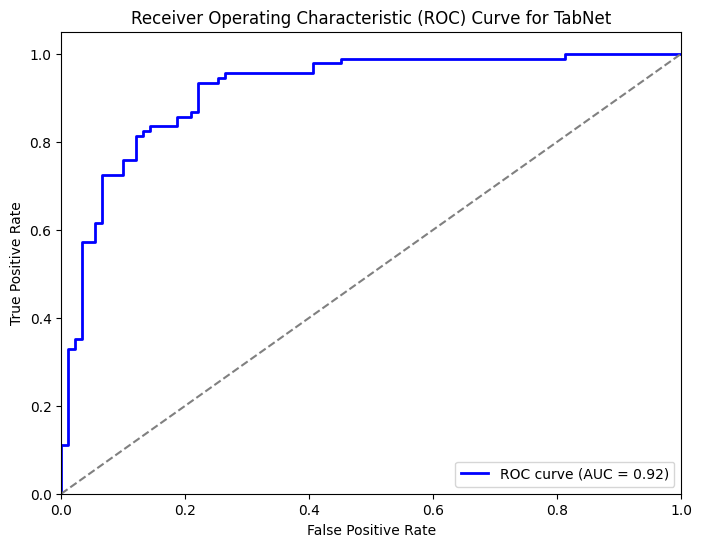

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_proba_tabnet = tabnet.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr_tabnet, tpr_tabnet, thresholds_tabnet = roc_curve(y_test, y_proba_tabnet)
roc_auc_tabnet = auc(fpr_tabnet, tpr_tabnet)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tabnet, tpr_tabnet, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_tabnet:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for TabNet')
plt.legend(loc='lower right')
plt.show()


TabNet Interpretability

In [ ]:
# Get global feature importance (aggregated over all training data)
feature_importances = tabnet.feature_importances_

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.title("TabNet Global Feature Importance")
plt.xlabel("Importance Score")
plt.show()

## FT-Transformer

In [ ]:
!pip install rtdl

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import rtdl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.5.2 requires torch>=2.0.0, but you have torch 1.13.1 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 1.13.1 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 1.13.1 w

In [ ]:
import numpy as np

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Define FT-Transformer model
model = rtdl.FTTransformer.make_default(
    n_num_features=X_train.shape[1],  # Number of input features
    cat_cardinalities=None,  # No categorical features
    d_out=len(np.unique(y_train))  # Number of classes
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Pass `None` for categorical input since we only have numerical features
    y_pred = model(X_train_torch.to(device), x_cat=None)

    loss = criterion(y_pred, y_train_torch.to(device))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_torch.to(device), x_cat=None).argmax(dim=1).cpu().numpy()

# Print classification report

print(classification_report(y_test, y_pred_test))



Epoch 0/50, Loss: 0.7096
Epoch 10/50, Loss: 0.2507
Epoch 20/50, Loss: 0.2088
Epoch 30/50, Loss: 0.1825
Epoch 40/50, Loss: 0.1498
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        91
           1       0.83      0.95      0.89        91

    accuracy                           0.88       182
   macro avg       0.89      0.88      0.88       182
weighted avg       0.89      0.88      0.88       182



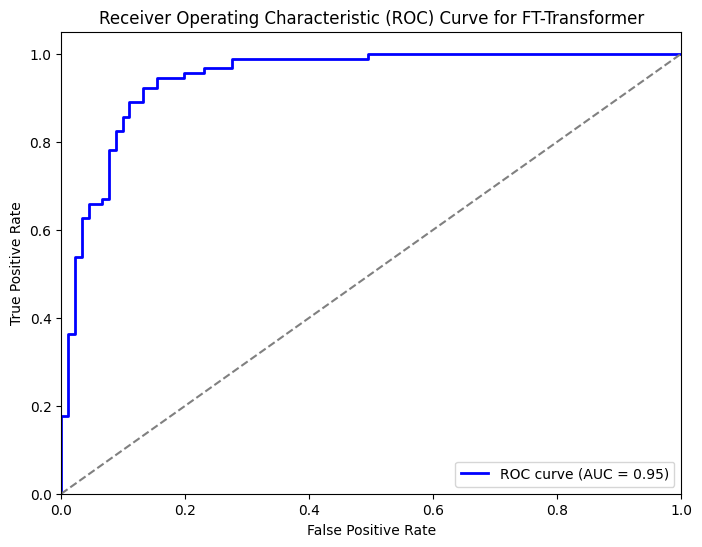

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F


# Get predicted probabilities for the positive class (class 1)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred = model(X_test_torch, x_cat=None)  # Get logits for the test data
    y_pred_probs = F.softmax(y_pred, dim=1)[:, 1]  # Get probabilities for the positive class (class 1)

# Calculate ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test_torch.cpu(), y_pred_probs.cpu())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for FT-Transformer')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Train eval
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_torch.to(device), x_cat=None).argmax(dim=1).cpu().numpy()

# Print classification report

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       273
           1       0.95      0.96      0.95       273

    accuracy                           0.95       546
   macro avg       0.95      0.95      0.95       546
weighted avg       0.95      0.95      0.95       546



In [ ]:
# Define FT-Transformer model with attention output only
class FTTransformerWithAttention(rtdl.FTTransformer):
    def forward(self, x_num, x_cat=None):
        out, attention_scores = self.transformer(x_num, x_cat, return_attention=True)
        return attention_scores  # Return attention scores only

# Initialize model
model = FTTransformerWithAttention.make_default(
    n_num_features=X_train.shape[1],
    cat_cardinalities=None,
    d_out=len(np.unique(y_train))
).to(device)

# Extract attention scores for X_test
with torch.no_grad():
    attention_scores = model(X_test_torch.to(device), x_cat=None)

# attention_scores shape: (batch_size, num_layers, num_heads, num_features, num_features)
attention_scores = attention_scores.cpu().numpy()


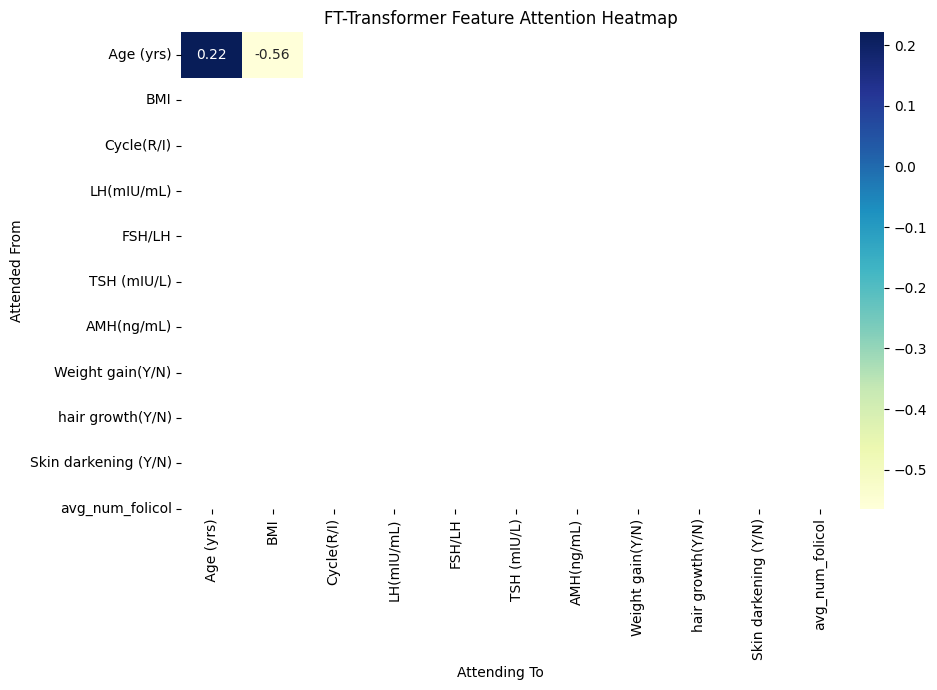

In [ ]:
# Aggregate attention scores: mean over layers and heads
mean_attention = np.mean(attention_scores, axis=0)
mean_attention_2d = mean_attention.reshape(1, -1)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(mean_attention_2d, annot=True, cmap="YlGnBu",
            xticklabels=X_train.columns, yticklabels=X_train.columns, fmt=".2f")
plt.title("FT-Transformer Feature Attention Heatmap")
plt.xlabel("Attending To")
plt.ylabel("Attended From")
plt.tight_layout()
plt.show()


## TabPFN

In [ ]:
!pip install tabpfn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
from tabpfn import TabPFNClassifier

In [ ]:
# Initialize the TabPFN model
model = TabPFNClassifier(device="cpu")  # Use "cuda" if you have a GPU

# Train the model (TabPFN trains instantly, no need for epochs)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Show classification report

print(classification_report(y_test, y_pred))

# Train eval
y_train_pred = model.predict(X_train)
print(classification_report(y_train_pred, y_train))

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tabpfn/classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)


              precision    recall  f1-score   support

           0       0.95      0.86      0.90        91
           1       0.87      0.96      0.91        91

    accuracy                           0.91       182
   macro avg       0.91      0.91      0.91       182
weighted avg       0.91      0.91      0.91       182

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       274
           1       0.98      0.98      0.98       272

    accuracy                           0.98       546
   macro avg       0.98      0.98      0.98       546
weighted avg       0.98      0.98      0.98       546



In [ ]:
from sklearn.metrics import classification_report
# Initialize the TabPFN model
model = TabPFNClassifier(device="cpu")  # Use "cuda" if you have a GPU

# Train the model (TabPFN trains instantly, no need for epochs)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tabpfn/classifier.py:432: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


              precision    recall  f1-score   support

           0       0.61      0.57      0.59       132
           1       0.55      0.60      0.58       118

    accuracy                           0.58       250
   macro avg       0.58      0.58      0.58       250
weighted avg       0.59      0.58      0.58       250



In [ ]:
# On synthetic
y_pred_syn = model.predict(X_test_syn)
print(classification_report(y_pred_syn, y_test_syn))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       109
           1       0.93      0.82      0.87       141

    accuracy                           0.86       250
   macro avg       0.86      0.87      0.86       250
weighted avg       0.87      0.86      0.86       250



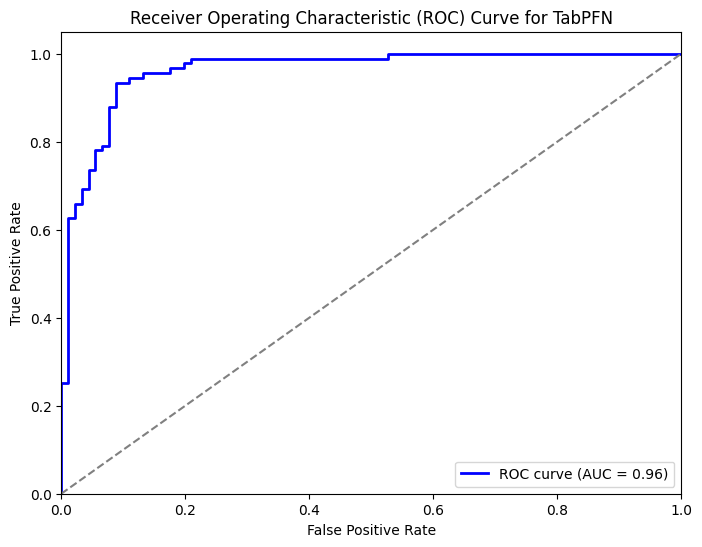

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_proba_tabpfn = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC AUC
fpr_tabpfn, tpr_tabpfn, thresholds_tabpfn = roc_curve(y_test, y_proba_tabpfn)
roc_auc_tabpfn = auc(fpr_tabpfn, tpr_tabpfn)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tabpfn, tpr_tabpfn, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_tabpfn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for TabPFN')
plt.legend(loc='lower right')
plt.show()


Quantifying uncertainties

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tabpfn/classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)


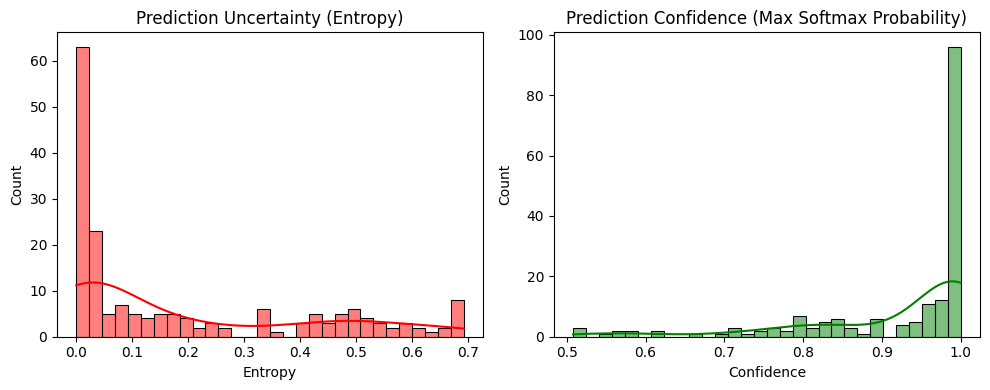

In [ ]:
# Initialize the TabPFN model
model = TabPFNClassifier(device="cpu")  # Use "cuda" if you have a GPU

# Train the model (TabPFN trains instantly, no need for epochs)
model.fit(X_train, y_train)

# Get predicted probabilities for test set
y_proba = model.predict_proba(X_test)

##### COMPUTE ENTROPY AND CONFIDENCE ########
import numpy as np

# Entropy: measure of uncertainty
def compute_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-9), axis=1)  # small epsilon for numerical stability

# Confidence: 1 - uncertainty
def compute_confidence(probs):
    return np.max(probs, axis=1)

entropies = compute_entropy(y_proba)
confidences = compute_confidence(y_proba)

####### VISUALIZE #######
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of entropy (uncertainty)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(entropies, bins=30, kde=True, color='red')
plt.title("Prediction Uncertainty (Entropy)")
plt.xlabel("Entropy")
plt.ylabel("Count")

# Plot histogram of confidence
plt.subplot(1, 2, 2)
sns.histplot(confidences, bins=30, kde=True, color='green')
plt.title("Prediction Confidence (Max Softmax Probability)")
plt.xlabel("Confidence")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


# Prototypical Network

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Reduce feature dimensions with PCA
pca = PCA(n_components=5)  # Reduce to 5 dimensions for simplicity
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:
# Compute class prototypes
proto_0 = np.mean(X_train_pca[y_train == 0], axis=0)  # Prototype for Non-PCOS
proto_1 = np.mean(X_train_pca[y_train == 1], axis=0)  # Prototype for PCOS

prototypes = np.vstack([proto_0, proto_1])


In [ ]:
from scipy.spatial.distance import cdist

# Compute distances to prototypes
distances = cdist(X_test_pca, prototypes, metric='euclidean')

# Predict the closest class (0 or 1)
y_pred = np.argmin(distances, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.87      0.84        91
           1       0.86      0.79      0.82        91

    accuracy                           0.83       182
   macro avg       0.83      0.83      0.83       182
weighted avg       0.83      0.83      0.83       182



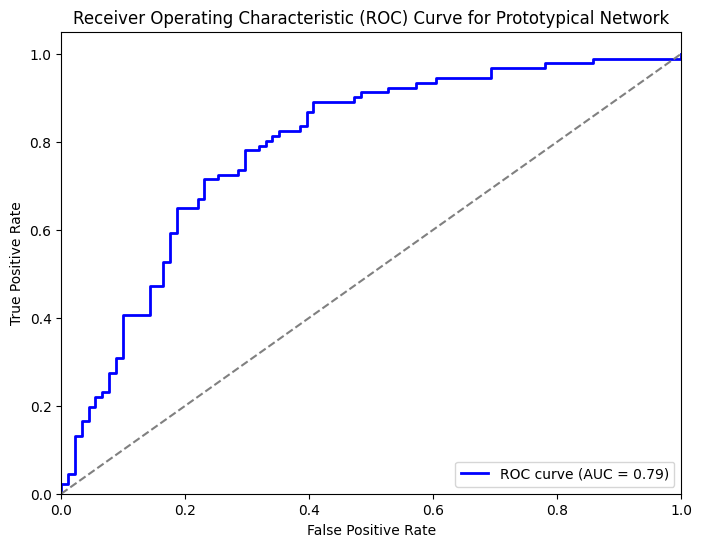

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Compute the inverse of distances (smaller distance = higher confidence)
# You could use other normalization techniques if necessary
distances_to_1 = distances[:, 1]  # Distance to prototype for class 1 (PCOS)
distances_to_0 = distances[:, 0]  # Distance to prototype for class 0 (Non-PCOS)

# We use the distance to class 1 as a proxy for the probability of being class 1
y_proba_proto = 1 / (1 + distances_to_1)  # Inverse distance (closer = more confident)

# Compute ROC curve and ROC AUC
fpr_proto, tpr_proto, thresholds_proto = roc_curve(y_test, y_proba_proto)
roc_auc_proto = auc(fpr_proto, tpr_proto)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_proto, tpr_proto, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_proto:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Prototypical Network')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Compute distances of training samples to prototypes
train_distances = cdist(X_train_pca, prototypes, metric='euclidean')

# Predict the closest class (0 or 1) for training set
y_train_pred = np.argmin(train_distances, axis=1)

# Print classification report for training set
print("\n--- Training Set Classification Report ---\n")
print(classification_report(y_train, y_train_pred, target_names=["No PCOS", "PCOS"]))



--- Training Set Classification Report ---

              precision    recall  f1-score   support

     No PCOS       0.83      0.89      0.86       273
        PCOS       0.88      0.81      0.85       273

    accuracy                           0.85       546
   macro avg       0.86      0.85      0.85       546
weighted avg       0.86      0.85      0.85       546



# MAML

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Convert PCOS data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Split dataset
X_train, X_meta, y_train, y_meta = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create Dataloader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)

# Simple Feedforward Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 2)  # Binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Initialize model
input_dim = X.shape[1]
model = SimpleNN(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train on Main Dataset
for epoch in range(5):  # Train for a few epochs
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

# Save Pre-trained Model (Meta-Learned Model)
torch.save(model.state_dict(), "pretrained_model.pth")
print("Pre-trained model saved!")


Pre-trained model saved!


In [ ]:
# Load Pre-trained Model
model.load_state_dict(torch.load("pretrained_model.pth"))

# Prepare small fine-tuning dataset
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_meta, y_meta, test_size=0.5, random_state=42)

meta_train_loader = DataLoader(TensorDataset(X_meta_train, y_meta_train), batch_size=4, shuffle=True)

# Fine-tune on Small PCOS Subset (Simulating MAML's Fast Adaptation)
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Higher LR for fast adaptation

for epoch in range(3):  # Only a few steps!
    for X_batch, y_batch in meta_train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

print("Fast adaptation done!")


Fast adaptation done!


In [ ]:
from sklearn.metrics import classification_report

def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_labels = torch.argmax(y_pred, dim=1)

    acc = (y_pred_labels == y_test).float().mean().item()
    report = classification_report(y_test.numpy(), y_pred_labels.numpy(), target_names=["No PCOS", "PCOS"])

    print(f"Test Accuracy After Fine-Tuning: {acc:.4f}")
    print("\nClassification Report:\n", report)
    return report  # Return classification report

# Run Evaluation
evaluate(model, X_meta_test, y_meta_test)


Test Accuracy After Fine-Tuning: 0.9178

Classification Report:
               precision    recall  f1-score   support

     No PCOS       0.90      0.90      0.90        31
        PCOS       0.93      0.93      0.93        42

    accuracy                           0.92        73
   macro avg       0.92      0.92      0.92        73
weighted avg       0.92      0.92      0.92        73



'              precision    recall  f1-score   support\n\n     No PCOS       0.90      0.90      0.90        31\n        PCOS       0.93      0.93      0.93        42\n\n    accuracy                           0.92        73\n   macro avg       0.92      0.92      0.92        73\nweighted avg       0.92      0.92      0.92        73\n'

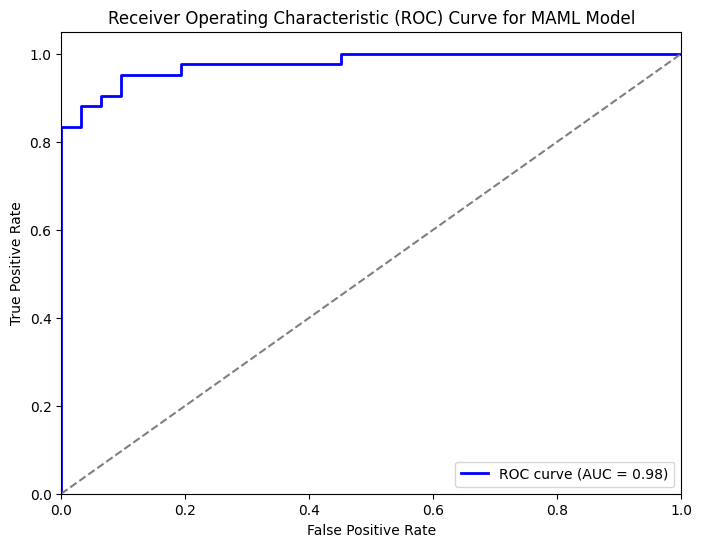

ROC-AUC for the fine-tuned MAML model: 0.9770


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

# Evaluate model on the meta-test set for ROC-AUC
def evaluate_roc_auc(model, X_test, y_test):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get logits for the test data
        y_pred_logits = model(X_test)

        # Apply softmax to get probabilities for each class
        y_pred_probs = F.softmax(y_pred_logits, dim=1)[:, 1]  # Probability for class 1 (PCOS)

    # Compute ROC curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs.numpy())
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for MAML Model')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

# Run the ROC-AUC evaluation for the fine-tuned model
roc_auc = evaluate_roc_auc(model, X_meta_test, y_meta_test)
print(f"ROC-AUC for the fine-tuned MAML model: {roc_auc:.4f}")


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate(model, X_train, y_train, X_test, y_test):
    model.eval()

    with torch.no_grad():
        # Predictions on Training Set
        y_train_pred = model(X_train)
        y_train_pred_labels = torch.argmax(y_train_pred, dim=1)
        train_acc = accuracy_score(y_train.numpy(), y_train_pred_labels.numpy())

        # Predictions on Test Set
        y_test_pred = model(X_test)
        y_test_pred_labels = torch.argmax(y_test_pred, dim=1)
        test_acc = accuracy_score(y_test.numpy(), y_test_pred_labels.numpy())

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Classification Reports
    print("\n--- Training Set Classification Report ---\n")
    print(classification_report(y_train.numpy(), y_train_pred_labels.numpy(), target_names=["No PCOS", "PCOS"]))

    print("\n--- Test Set Classification Report ---\n")
    print(classification_report(y_test.numpy(), y_test_pred_labels.numpy(), target_names=["No PCOS", "PCOS"]))

    return train_acc, test_acc

# Run Evaluation
train_acc, test_acc = evaluate(model, X_train, y_train, X_meta_test, y_meta_test)


Training Accuracy: 0.8849
Test Accuracy: 0.9178

--- Training Set Classification Report ---

              precision    recall  f1-score   support

     No PCOS       0.90      0.86      0.88       293
        PCOS       0.87      0.91      0.89       289

    accuracy                           0.88       582
   macro avg       0.89      0.89      0.88       582
weighted avg       0.89      0.88      0.88       582


--- Test Set Classification Report ---

              precision    recall  f1-score   support

     No PCOS       0.90      0.90      0.90        31
        PCOS       0.93      0.93      0.93        42

    accuracy                           0.92        73
   macro avg       0.92      0.92      0.92        73
weighted avg       0.92      0.92      0.92        73

